<a href="https://colab.research.google.com/github/RichardDominik/neural-networks-CV/blob/master/NN_CV_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Domáca úloha č. 1 

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
from matplotlib import pyplot as plt

Načítanie datasetu Cifar 10

In [11]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
transform = transforms.ToTensor()
generator = torch.Generator().manual_seed(42)

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainset, valset = torch.utils.data.random_split(dataset, [45000, 5000], generator=generator)

Files already downloaded and verified
Files already downloaded and verified


Zobrazenie obrázkov z datasetu

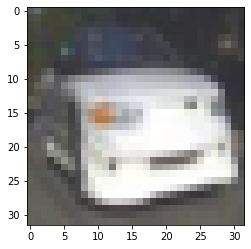

car


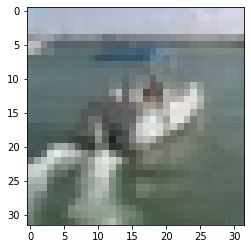

ship


In [12]:
previewloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

for i, sample in enumerate(previewloader):
  if i > 1:
    break
  x, y = sample
  img = np.moveaxis(x.numpy()[0], 0, -1)
  plt.imshow(img)
  plt.show()
  print(classes[y.item()])

# Základný model

Training loss at step 0: 2.2993857860565186
Training loss at step 100: 1.9624378681182861
Training loss at step 200: 2.089033365249634
Training loss at step 300: 2.0501952171325684
Training loss at step 400: 1.7849929332733154
Training loss at step 500: 1.5414044857025146
Training loss at step 600: 1.7329238653182983
Training loss at step 700: 1.4485498666763306
Training loss at step 800: 1.4178111553192139
Training loss at step 900: 1.4663822650909424
Training loss at step 1000: 1.4433159828186035
Training loss at step 1100: 1.6722463369369507
Training loss at step 1200: 1.4790551662445068
Training loss at step 1300: 1.4964038133621216
Training loss at step 1400: 1.4591305255889893
Val loss at epoch 0: 1.3990589942142462
Val acc at epoch 0: 0.4926
Training loss at step 0: 1.2751961946487427
Training loss at step 100: 1.4159200191497803
Training loss at step 200: 1.3973661661148071
Training loss at step 300: 1.2777090072631836
Training loss at step 400: 1.180396556854248
Training loss 

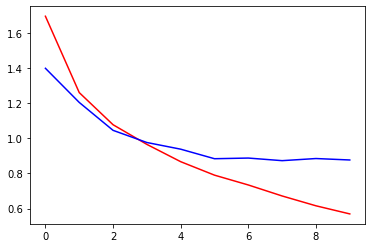

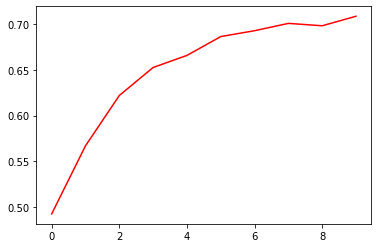

In [46]:
from torch.nn import Sequential, Linear, ReLU, Softmax, Conv2d, MaxPool2d, Flatten, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

# skusit velkost kernelu 5 
KERNEL_SIZE_CONV = 3
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
#viac ako X epoch overfitting
NUMBER_OF_EPOCHS = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model, model_inference = build_model()
model, model_inference = model.to(device), model_inference.to(device)

dataloader_train = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)

ce_loss = CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

epoch_train_losses = []
epoch_val_losses = []
epoch_val_accs = []

def build_model():
  model = Sequential(Conv2d(3, 32, KERNEL_SIZE_CONV), MaxPool2d(2), ReLU(), 
                    Conv2d(32, 64, KERNEL_SIZE_CONV), MaxPool2d(2), ReLU(),
                    Conv2d(64, 128, KERNEL_SIZE_CONV), MaxPool2d(2), ReLU(),
                    Flatten(), 
                    Linear(512, 256), ReLU(), Linear(256, 128), ReLU(),
                    Linear(128, 10))

  # dim=1
  model_inference = Sequential(model, Softmax())
  return model, model_inference

# model, model_inference = build_model()
# model_inference(torch.from_numpy(np.zeros([1, 3, 32, 32], dtype=np.float32)))

def one_epoch(model, loss, optimizer, dataloader_train, dataloader_val, device, verbose=True):
  train_losses = []
  val_losses = []

  model.train()

  for i, batch in enumerate(dataloader_train):  
    x, y = batch[0].to(device), batch[1].to(device) 
    optimizer.zero_grad()

    out = model(x)
    loss = ce_loss(out, y)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    if i % 100 == 0 and verbose:
      print("Training loss at step {}: {}".format(i, loss.item()))

  model.eval()

  with torch.no_grad():
    correct = 0
    total = 0
    for i, batch in enumerate(dataloader_val):  
      x, y = batch[0].to(device), batch[1].to(device)  

      out = model(x)
      loss = ce_loss(out, y)
      acc = torch.sum(torch.argmax(out, dim=-1) == y)
      correct += acc.item()
      total += len(batch[1])
      val_losses.append(loss.item())

  val_acc = correct / total

  return np.mean(train_losses), np.mean(val_losses), val_acc

for e in range(NUMBER_OF_EPOCHS):
  train_loss, val_loss, val_acc = one_epoch(model, ce_loss, optimizer, dataloader_train, dataloader_val, device)

  print("Val loss at epoch {}: {}".format(e, val_loss))
  print("Val acc at epoch {}: {}".format(e, val_acc))

  epoch_train_losses.append(train_loss)
  epoch_val_losses.append(val_loss)
  epoch_val_accs.append(val_acc)

# pridat nazvy + legendy
plt.plot(epoch_train_losses, c='r')
plt.plot(epoch_val_losses, c='b')
plt.show()

plt.plot(epoch_val_accs, c='r')
plt.show()

# Aktivácie

Funkcie pre budovanie modelov. Oskúšané aktivačné funkcie: Sigmoid, tanh, ELU, LeakyReLU a PReLU

In [51]:
from torch.nn import Sigmoid, Tanh, ELU, LeakyReLU, PReLU

# Sigmoid
def build_model_using_sigmoid_activation_function():
  model = Sequential(Conv2d(3, 32, KERNEL_SIZE_CONV), MaxPool2d(2), Sigmoid(), 
                    Conv2d(32, 64, KERNEL_SIZE_CONV), MaxPool2d(2), Sigmoid(),
                    Conv2d(64, 128, KERNEL_SIZE_CONV), MaxPool2d(2), Sigmoid(),
                    Flatten(), 
                    Linear(512, 256), Sigmoid(), Linear(256, 128), Sigmoid(),
                    Linear(128, 10))

  model_inference = Sequential(model, Softmax())
  return model, model_inference

# Tanh
def build_model_using_tanh_activation_function():
  model = Sequential(Conv2d(3, 32, KERNEL_SIZE_CONV), MaxPool2d(2), Tanh(), 
                  Conv2d(32, 64, KERNEL_SIZE_CONV), MaxPool2d(2), Tanh(),
                  Conv2d(64, 128, KERNEL_SIZE_CONV), MaxPool2d(2), Tanh(),
                  Flatten(), 
                  Linear(512, 256), Tanh(), Linear(256, 128), Tanh(),
                  Linear(128, 10))

  model_inference = Sequential(model, Softmax())
  return model, model_inference

# ELU
def build_model_using_elu_activation_function():
  model = Sequential(Conv2d(3, 32, KERNEL_SIZE_CONV), MaxPool2d(2), ELU(), 
                  Conv2d(32, 64, KERNEL_SIZE_CONV), MaxPool2d(2), ELU(),
                  Conv2d(64, 128, KERNEL_SIZE_CONV), MaxPool2d(2), ELU(),
                  Flatten(), 
                  Linear(512, 256), ELU(), Linear(256, 128), ELU(),
                  Linear(128, 10))

  model_inference = Sequential(model, Softmax())
  return model, model_inference

# LeakyReLu
ALPHA = 0.1

def build_model_using_leaky_relu_activation_function():
  model = Sequential(Conv2d(3, 32, KERNEL_SIZE_CONV), MaxPool2d(2), LeakyReLU(ALPHA), 
                  Conv2d(32, 64, KERNEL_SIZE_CONV), MaxPool2d(2), LeakyReLU(ALPHA),
                  Conv2d(64, 128, KERNEL_SIZE_CONV), MaxPool2d(2), LeakyReLU(ALPHA),
                  Flatten(), 
                  Linear(512, 256), LeakyReLU(ALPHA), Linear(256, 128), LeakyReLU(ALPHA),
                  Linear(128, 10))

  model_inference = Sequential(model, Softmax())
  return model, model_inference

# PReLU
def build_model_using_prelu_activation_function():
  model = Sequential(Conv2d(3, 32, KERNEL_SIZE_CONV), MaxPool2d(2), PReLU(), 
                  Conv2d(32, 64, KERNEL_SIZE_CONV), MaxPool2d(2), PReLU(),
                  Conv2d(64, 128, KERNEL_SIZE_CONV), MaxPool2d(2), PReLU(),
                  Flatten(), 
                  Linear(512, 256), PReLU(), Linear(256, 128), PReLU(),
                  Linear(128, 10))

  model_inference = Sequential(model, Softmax())
  return model, model_inference

Inicialializácia modelov podľa aktivačných funkcií

In [53]:
# Sigmoid model
sigmoid_model, sigmoid_model_inference = build_model_using_sigmoid_activation_function()
sigmoid_model, sigmoid_model_inference = sigmoid_model.to(device), sigmoid_model_inference.to(device)

# Tanh model
tanh_model, tanh_model_inference = build_model_using_tanh_activation_function()
tanh_model, tanh_model_inference = tanh_model.to(device), tanh_model_inference.to(device)

# ELU model
elu_model, elu_model_inference = build_model_using_elu_activation_function()
elu_model, elu_model_inference = elu_model.to(device), elu_model_inference.to(device)

# LeakyReLu model
leaky_relu_model, leaky_relu_model_inference = build_model_using_leaky_relu_activation_function()
leaky_relu_model, leaky_relu_model_inference = leaky_relu_model.to(device), leaky_relu_model_inference.to(device)

# PReLU model
prelu_model, prelu_model_inference = build_model_using_prelu_activation_function()
prelu_model, prelu_model_inference = prelu_model.to(device), prelu_model_inference.to(device)

# All models
models = [('sigmoid', sigmoid_model), ('tanh', tanh_model), ('elu', elu_model), ('leaky relu', leaky_relu_model), ('prelu', prelu_model)]

Trénovanie modelov

sigmoid
Val loss at epoch 0: 1.94623713812251
Val acc at epoch 0: 0.2652
Val loss at epoch 1: 1.8008255776326367
Val acc at epoch 1: 0.3352
Val loss at epoch 2: 1.6758446997138345
Val acc at epoch 2: 0.3828
Val loss at epoch 3: 1.6270160409295635
Val acc at epoch 3: 0.4126
Val loss at epoch 4: 1.5443251599931413
Val acc at epoch 4: 0.4346
Val loss at epoch 6: 1.4303521753116777
Val acc at epoch 6: 0.4804
Val loss at epoch 7: 1.4398744197408104
Val acc at epoch 7: 0.4844
Val loss at epoch 8: 1.3322594465723463
Val acc at epoch 8: 0.5192
Val loss at epoch 9: 1.305718781462141
Val acc at epoch 9: 0.529



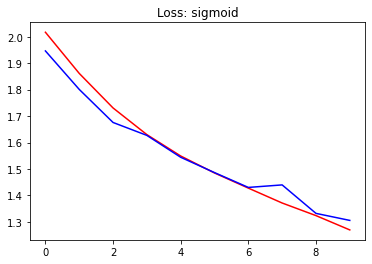

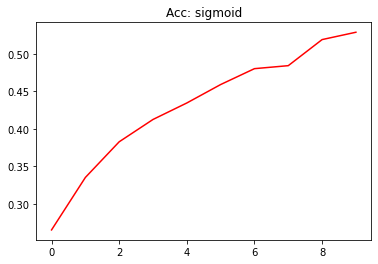

tanh
Val loss at epoch 0: 1.2939503652274988
Val acc at epoch 0: 0.5338
Val loss at epoch 1: 1.0863164997404549
Val acc at epoch 1: 0.6186
Val loss at epoch 2: 1.0028489976172235
Val acc at epoch 2: 0.6464
Val loss at epoch 3: 0.9574195590748149
Val acc at epoch 3: 0.6642
Val loss at epoch 4: 0.9485750982336177
Val acc at epoch 4: 0.673
Val loss at epoch 5: 0.9265735242397163
Val acc at epoch 5: 0.6888
Val loss at epoch 6: 0.9702455445080046
Val acc at epoch 6: 0.679
Val loss at epoch 7: 1.0605720854868554
Val acc at epoch 7: 0.6694
Val loss at epoch 8: 1.0714067273838506
Val acc at epoch 8: 0.6748
Val loss at epoch 9: 1.1298872915802487
Val acc at epoch 9: 0.6744



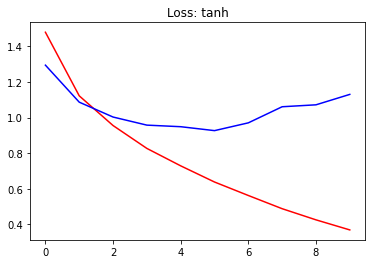

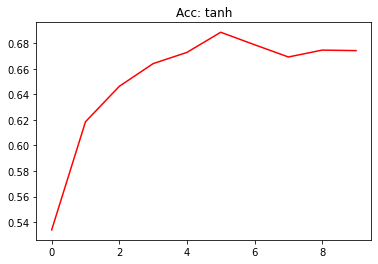

elu
Val loss at epoch 0: 1.193674233309023
Val acc at epoch 0: 0.5792
Val loss at epoch 1: 1.0315287217592737
Val acc at epoch 1: 0.638
Val loss at epoch 2: 0.9352865549409466
Val acc at epoch 2: 0.6728
Val loss at epoch 3: 0.8633876606157631
Val acc at epoch 3: 0.6942
Val loss at epoch 4: 0.8551683930834387
Val acc at epoch 4: 0.7116
Val loss at epoch 5: 0.8650295411705211
Val acc at epoch 5: 0.715
Val loss at epoch 6: 0.9363221400862287
Val acc at epoch 6: 0.7212
Val loss at epoch 7: 1.0117640766748197
Val acc at epoch 7: 0.7108
Val loss at epoch 8: 1.0305766157663552
Val acc at epoch 8: 0.715
Val loss at epoch 9: 1.1715147547471296
Val acc at epoch 9: 0.7162



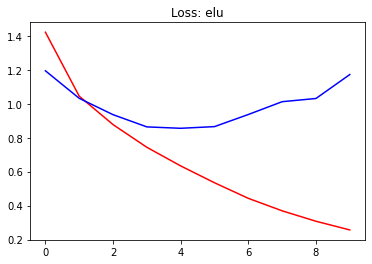

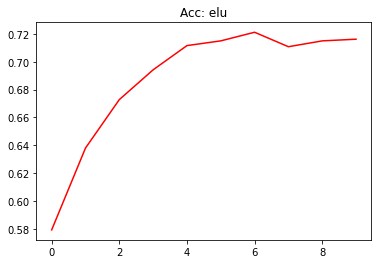

leaky relu
Val loss at epoch 0: 1.273857979637802
Val acc at epoch 0: 0.5446
Val loss at epoch 1: 1.0132088706751539
Val acc at epoch 1: 0.6374
Val loss at epoch 2: 0.8697055496607616
Val acc at epoch 2: 0.6938
Val loss at epoch 3: 0.8450689412605991
Val acc at epoch 3: 0.7042
Val loss at epoch 4: 0.8148482831040765
Val acc at epoch 4: 0.7244
Val loss at epoch 5: 0.8232100235808427
Val acc at epoch 5: 0.7296
Val loss at epoch 6: 0.857180145325934
Val acc at epoch 6: 0.7256
Val loss at epoch 7: 0.8992859382348456
Val acc at epoch 7: 0.728
Val loss at epoch 8: 0.9934115397512533
Val acc at epoch 8: 0.7226
Val loss at epoch 9: 1.0309615735984912
Val acc at epoch 9: 0.721



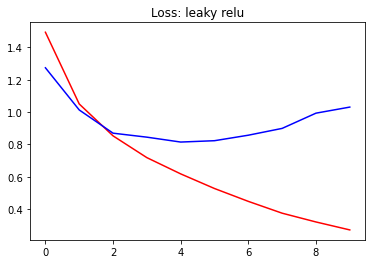

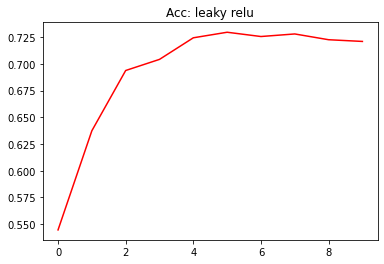

prelu
Val loss at epoch 0: 1.253687753419208
Val acc at epoch 0: 0.5496
Val loss at epoch 1: 0.9896623325196041
Val acc at epoch 1: 0.6458
Val loss at epoch 2: 1.0014011704238357
Val acc at epoch 2: 0.6462
Val loss at epoch 3: 0.9011879574721027
Val acc at epoch 3: 0.6776
Val loss at epoch 4: 0.8685538292310799
Val acc at epoch 4: 0.6982
Val loss at epoch 5: 0.8760734709205141
Val acc at epoch 5: 0.704
Val loss at epoch 6: 0.8730589897389625
Val acc at epoch 6: 0.7206
Val loss at epoch 7: 0.9767076303814627
Val acc at epoch 7: 0.72
Val loss at epoch 8: 1.0294043047792594
Val acc at epoch 8: 0.7204
Val loss at epoch 9: 1.104599603042481
Val acc at epoch 9: 0.7286



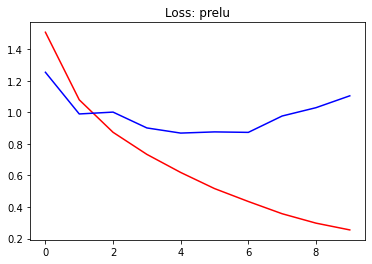

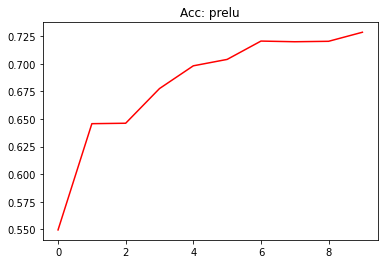

In [57]:
for activation_function_name, model in models:
  optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
  epoch_train_losses = []
  epoch_val_losses = []
  epoch_val_accs = []

  print(activation_function_name) 

  for e in range(NUMBER_OF_EPOCHS):
    train_loss, val_loss, val_acc = one_epoch(model, ce_loss, optimizer, dataloader_train, dataloader_val, device, False)

    print("Val loss at epoch {}: {}".format(e, val_loss))
    print("Val acc at epoch {}: {}".format(e, val_acc))

    epoch_train_losses.append(train_loss)
    epoch_val_losses.append(val_loss)
    epoch_val_accs.append(val_acc)

  print('')

  # pridat nazvy + legendy
  plt.title('Loss: ' + activation_function_name)
  plt.plot(epoch_train_losses, c='r')
  plt.plot(epoch_val_losses, c='b')
  plt.show()

  plt.title('Acc: ' + activation_function_name)
  plt.plot(epoch_val_accs, c='r')
  plt.show()

# Optimalizácia

# Dropout a Augmentácia 

# Hlboká sieť (5b)

# Najlepší model 